使用pandas读入数据并处理数据

In [16]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

train_data = pd.read_csv(r"../data/kaggle_house_pred/train.csv")
test_data = pd.read_csv(r"../data/kaggle_house_pred/test.csv")
# print(train_data.columns)
# print(test_data.columns)
print(train_data.shape) # (47439, 41)
print(test_data.shape) # (31626, 40),少了一个出售价格，需要我们预测

(47439, 41)
(31626, 40)


打印前四列，看看特征，以及相应标签，以便我们选择特征

In [17]:
train_data.iloc[0:4]

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA


在每个样本中，第一个特征是ID， 我们将其从数据集中删除

In [18]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # 注意：这里将训练集和测试集合并成了一个数据集，以便归一化数据

这里面有些特征我还是用不上，我只用一些常见的特征：Year built、Lot、Bedrooms、Bathrooms、Full bathrooms、Total spaces、High School Score、Tax assessed value、Annual tax amount、Listed Price、Last Sold Price、Zip


In [19]:
all_features = all_features.loc[:, ["Year built", "Lot", "Bathrooms", "Full bathrooms", "Total spaces",
                                "High School Score","Tax assessed value", "Annual tax amount", "Listed Price", "Last Sold Price", "Zip"]]
all_features

,Year built,Lot,Bathrooms,Full bathrooms,Total spaces,High School Score,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
0,1969.0,1.0,0.0,NaN,0.0,8.0,886486.0,12580.0,4198000.0,NaN,94022
1,1926.0,4047.0,2.0,2.0,1.0,2.0,505000.0,6253.0,525000.0,328000.0,90047
2,1958.0,9147.0,3.0,1.0,0.0,NaN,49627.0,468.0,180000.0,NaN,95375
3,1947.0,NaN,3.0,3.0,0.0,8.0,1775000.0,20787.0,1895000.0,1500000.0,90230
4,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1595000.0,900000.0,93432
...,...,...,...,...,...,...,...,...,...,...,...
31621,2019.0,NaN,6.0,NaN,0.0,7.0,4819317.0,53342.0,8500000.0,895500.0,95991
31622,1970.0,1626.0,2.0,1.0,2.0,NaN,296819.0,3195.0,330000.0,328000.0,92057
31623,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,443000.0,NaN,91941
31624,1984.0,NaN,3.0,2.0,2.0,6.0,334277.0,4032.0,445000.0,470000.0,92139


存在缺失值，因为有的是空的，先替换为nan，再删除

In [20]:
all_features.isnull() # 看看是否有nan值，也就是缺失值

,Year built,Lot,Bathrooms,Full bathrooms,Total spaces,High School Score,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
0,False,False,False,True,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,True,False
3,False,True,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
31621,False,True,False,True,False,False,False,False,False,False,False
31622,False,False,False,False,False,True,False,False,False,False,False
31623,True,True,True,True,True,False,True,True,False,True,False
31624,False,True,False,False,False,False,False,False,False,False,False


In [21]:
np.any(all_features.isnull())

True

发现有缺失值。

一、数值特征：将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据

In [22]:
# 获取数值特征的索引名
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 零均值和单位方差来标准化数据
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 因为已经标准化数据了，这些特征的缺失值用平均值0填充
print(numeric_features)

Index(['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total spaces',
       'High School Score', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')


二、离散值特征：用一次独热编码替换

In [23]:
# 字符串特征，则用one-hot编码替换
all_features = pd.get_dummies(all_features, dummy_na=True) # pd.get_dummies是：利用pandas实现one hot encode的方式
all_features.shape

(79065, 11)

从pandas格式中提取NumPy格式，并将其转换为张量表示

In [24]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data["Sold Price"].values.reshape(-1, 1),
                            dtype=torch.float32)
print(train_features.shape) # 两个维度，0维：样本数；1维：特征数
print(train_labels.shape) # 标签

torch.Size([47439, 11])
torch.Size([47439, 1])


训练

In [25]:
loss = nn.MSELoss() # 均方损失函数
in_features = train_features.shape[1] # 特征数

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 32),
                       nn.ReLU(),
                       nn.Linear(32, 16),
                       nn.ReLU(),
                       nn.Linear(16, 1)) # 多层感知机
    return net

我们更关心相对误差
$\frac{{{\rm{y}} - \hat y}}{y}$，（RMSE）解决这个问题的一种方法是用价格预测的对数来衡量差异

In [26]:
def log_rmse(net, features, labels):
    # torch.clamp函数：将输入input张量每个元素的夹紧到区间 [min,max][min,max]，并返回结果到一个新张量。这里是区间1~无穷大
    clipped_preds = torch.clamp(net(features), 1, float('inf')) 
    # 将标签和预测值取对数，并送入rmse中
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # 返回数值，而不是tensor

我们的训练函数将借助Adam优化器

In [27]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 将训练数据打包成batch_size大小，并可迭代取出
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad() # 梯度清零
            l = loss(net(X), y) # 计算损失，注意：pytorch会自动将向量转换成标量，以便反向传播计算导数
            l.backward() # 反向传播：计算梯度
            optimizer.step() # 更新参数
        train_ls.append(log_rmse(net, train_features, train_labels)) # 将训练的对数rmse保存下来，以便返回
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) # 将测试的对数rmse保存下来，以便返回
    return train_ls, test_ls

K折交叉验证

In [34]:
def get_k_fold_data(k, i, X, y): # i表示第几折
    assert k > 1
    fold_size = X.shape[0] // k # 分成k份,每折的大小
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # slice() 函数实现切片对象，主要用在切片操作函数里的参数传递。
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [37]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k): # 做k次
        data = get_k_fold_data(k, i, X_train, y_train) # 获取训练集和验证集
        net = get_net() # 模型
        
#         if torch.cuda.is_available():
#             net = net.cuda()
#             data = data.cuda()
        
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size) # 得到损失，注意：data传入的是列表
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0: # 画第1折训练的曲线
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

fold 1, train log rmse 0.544098, valid log rmse 0.505485
fold 2, train log rmse 0.308901, valid log rmse 0.292516
fold 3, train log rmse 0.525973, valid log rmse 0.512323
fold 4, train log rmse 0.347249, valid log rmse 0.359028
fold 5, train log rmse 0.490224, valid log rmse 0.546226
5-折验证: 平均训练log rmse: 0.443289, 平均验证log rmse: 0.443116


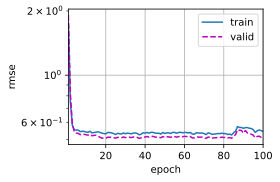

In [38]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.279844


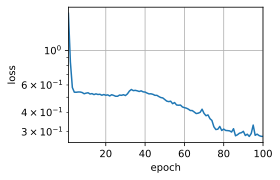

In [39]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='loss', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv(r'../data/kaggle_house_pred/submission.csv', index=False) # 将预测的房价结果保存下来

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)